# Investigate alpha abundances in astroNN DR17

## Packages, definitions, and settings

In [165]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from astropy.table import Table

# Plot settings
plt.rc(('xtick', 'ytick'), direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('font', family='STIXgeneral')
plt.rc('figure', dpi=140)

# Paths
# data_dir = '/users/PAS2055/lodubay/Data/APOGEE'
data_dir = 'C:\\Users\\dubay.11\\Data\\APOGEE'
data_path = Path(data_dir)
astroNN_file = 'apogee_astroNN-DR17.fits'

def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.

    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def rms(array, arrmin=None, arrmax=None, axis=None):
    """
    Return the root-mean-square of a given array

    """
    if arrmin:
        array = array[array > arrmin]
    if arrmax:
        array = array[array < arrmax]
    return np.sqrt(np.mean(array**2, axis=axis))

def quad_add(arr1, arr2):
    """
    Add input arrays in quadrature.
    
    """
    return np.sqrt(arr1**2 + arr2**2)

## Import astroNN data

In [60]:
# Import
data = Table.read(data_path / astroNN_file, format='fits')
df = decode(data.to_pandas())
# Cuts
df = df[df['FE_H_ERR'] <= 3]
df = df[df['O_H_ERR'] <= 3]
df = df[(df['FE_H'] <= 1) & (df['FE_H'] >= -4)]
# New columns
df['phot_g_abs_mag'] = df['phot_g_mean_mag'] - (5 * np.log10(df['weighted_dist']) - 5)
df['O_FE'] = df['O_H'] - df['FE_H']
df['O_FE_ERR'] = quad_add(df['O_H_ERR'], df['FE_H_ERR'])
print(df.columns.to_list())

['APOGEE_ID', 'LOCATION_ID', 'TELESCOPE', 'RA_APOGEE', 'DEC_APOGEE', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'C_H', 'C_H_ERR', 'CI_H', 'CI_H_ERR', 'N_H', 'N_H_ERR', 'O_H', 'O_H_ERR', 'NA_H', 'NA_H_ERR', 'MG_H', 'MG_H_ERR', 'AL_H', 'AL_H_ERR', 'SI_H', 'SI_H_ERR', 'P_H', 'P_H_ERR', 'S_H', 'S_H_ERR', 'K_H', 'K_H_ERR', 'CA_H', 'CA_H_ERR', 'TI_H', 'TI_H_ERR', 'TIII_H', 'TIII_H_ERR', 'V_H', 'V_H_ERR', 'CR_H', 'CR_H_ERR', 'MN_H', 'MN_H_ERR', 'FE_H', 'FE_H_ERR', 'CO_H', 'CO_H_ERR', 'NI_H', 'NI_H_ERR', 'dist', 'dist_error', 'dist_model_error', 'nn_parallax', 'nn_parallax_error', 'nn_parallax_model_error', 'fakemag', 'fakemag_error', 'weighted_dist', 'weighted_dist_error', 'RA', 'DEC', 'pmra', 'pmra_error', 'ref_epoch', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'g_rp', 'VHELIO_AVG', 'age', 'age_linear_correct', 'age_lowess_correct', 'age_total_error', 'age_model_error', 'source_id', 'galr', 'galphi', 'galz', 'galvr', 'galvt', 'galvz', 'galr_err', 'galphi_err', 'galz_err', 'galvr_err', 

C:\Users\dubay.11\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Distribution of alpha abundances

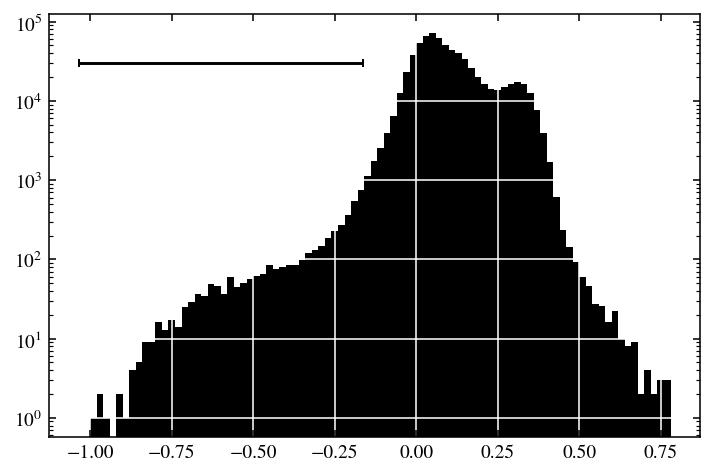

In [67]:
fig, ax = plt.subplots()
ax.hist(df['O_FE'], bins=np.arange(-1, 0.8, 0.02), color='k')
ax.errorbar(-0.6, 3e4, xerr=rms(df['O_FE_ERR']), c='k', capsize=2)
ax.grid(which='major', axis='both', color='w')
ax.set_yscale('log')
plt.show()

## CMD

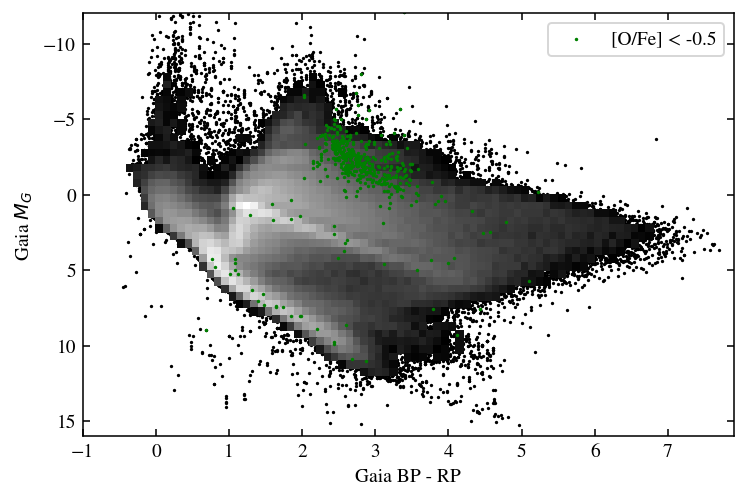

In [163]:
low_alpha = df[df['O_FE'] < -0.5].copy()

fig, ax = plt.subplots()
ax.scatter(df['bp_rp'], df['phot_g_abs_mag'], c='k', s=.5)
ax.hist2d(df['bp_rp'], df['phot_g_abs_mag'], 
          bins=[np.arange(-1, 8, 0.1), np.arange(-10, 15, 0.5)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(low_alpha['bp_rp'], low_alpha['phot_g_abs_mag'], c='g', s=.6, label='[O/Fe] < -0.5')
ax.set_ylim((16, -12))
ax.set_xlabel('Gaia BP - RP')
ax.set_ylabel('Gaia $M_G$')
ax.legend()
plt.show()

## Galactocentric coordinates

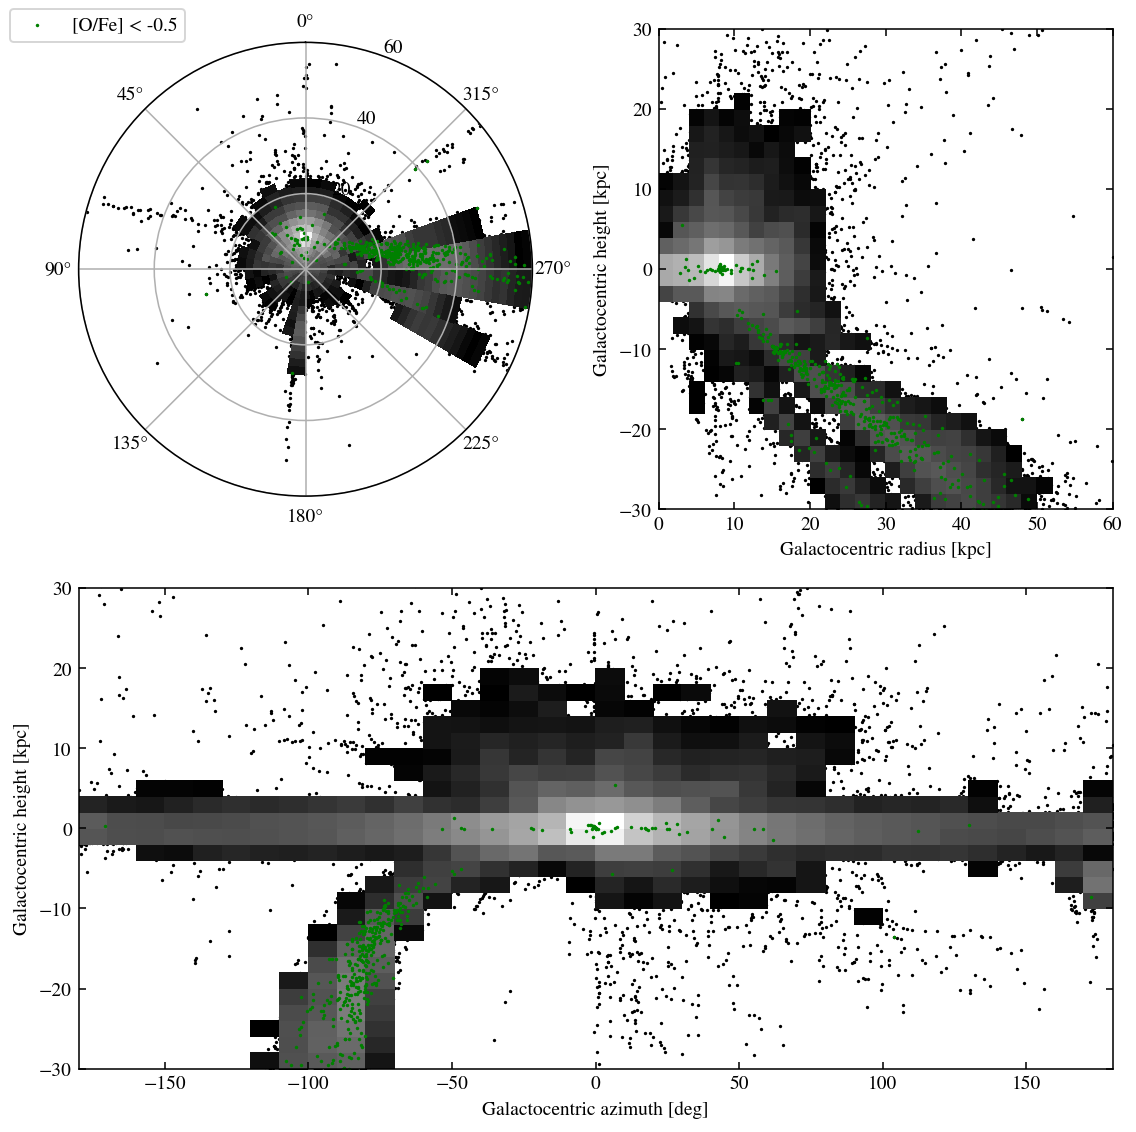

In [171]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0,0], projection='polar')
ax.scatter(df['galphi'], df['galr'], c='k', s=0.5)
ax.hist2d(df['galphi'], df['galr'], 
          bins=[np.linspace(-np.pi, np.pi, 37, endpoint=True), np.arange(0, 62, 2)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(low_alpha['galphi'], low_alpha['galr'], c='g', s=.6, label='[O/Fe] < -0.5')
ax.grid()
ax.set_theta_zero_location('N')
ax.set_rmax(60)
ax.set_rticks([20, 40, 60])
ax.set_rlabel_position(340)
ax.set_xlim((0, 2*np.pi))

ax = fig.add_subplot(gs[0,1])
ax.scatter(df['galr'], df['galz'], c='k', s=0.5)
ax.hist2d(df['galr'], df['galz'], 
          bins=[np.arange(0, 62, 2), np.arange(-30, 32, 2)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(low_alpha['galr'], low_alpha['galz'], c='g', s=.6)
ax.set_xlim((0, 60))
ax.set_ylim((-30, 30))
ax.set_xlabel('Galactocentric radius [kpc]')
ax.set_ylabel('Galactocentric height [kpc]')

ax = fig.add_subplot(gs[1,:])
ax.scatter(df['galphi'] * 180/np.pi, df['galz'], c='k', s=.5)
ax.hist2d(df['galphi'] * 180/np.pi, df['galz'], 
          bins=[np.linspace(-180, 180, 37, endpoint=True), np.arange(-30, 32, 2)], 
          cmap='gray', norm=colors.LogNorm(), cmin=10)
ax.scatter(low_alpha['galphi'] * 180/np.pi, low_alpha['galz'], c='g', s=.6)
ax.set_xlabel('Galactocentric azimuth [deg]')
ax.set_ylabel('Galactocentric height [kpc]')
fig.legend(loc='upper left')
plt.show()